<div align="center">
    <h1>Feminicidio en México, ¿10 casos al día?</h1>
    <h3>Pedro Andrés Hernández Amador</h3>
    <h4>3 de diciembre del 2021</h4>
</div>

El presente análisis se ha realizado como parte de las actividades de evaluación del módulo de probabilidad en el curso *Matemáticas para ciencia de datos* impartido en el primer semestre de la [Maestría en ciencia de datos de la Universidad de Sonora](https://mcd.unison.mx/).

El feminicidio se define como *el asesinato intencional de una mujer sólo por ser mujer*, aunque algunas otras definiciones consideran como feminicidio a cualquier caso de asesinato donde las víctimas sean mujeres o niñas, [[1]](https://apps.who.int/iris/bitstream/handle/10665/77421/WHO_RHR_12.38_eng.pdf) en este trabajo nos apegaremos al último caso.

Este delito se ha convertido en uno de los principales y más graves problemas que el México actual enfrenta. Una dato importante (y alarmante) que en los últimos meses se ha divulgado en diferentes medios de comunicación es que **cada día 10 mujeres son asesinadas en el país**. [[2]](https://www.eleconomista.com.mx/politica/Solo-en-los-primeros-seis-meses-del-2020-fueron-asesinadas-1844-mujeres-en-Mexico-Inegi-20210213-0002.html), [[3]](https://elpais.com/mexico/2021-06-28/los-feminicidios-en-mexico-aumentan-un-71-en-los-cinco-primeros-meses-de-2021.html), [[4]](https://www.jornada.com.mx/notas/2021/11/20/politica/asesinadas-10-mujeres-al-dia-en-mexico-senala-ai/). De acuerdo a *El Financiero* [[5]](https://www.elfinanciero.com.mx/nacional/en-2020-cada-2-horas-y-media-asesinaron-a-una-mujer-en-mexico/), el año pasado **Cada 2 horas y media una mujer fue asesinada**, es decir, **9.6 mujeres al día**. 

El objetivo principal de este análisis es realizar una prueba de hipótesis utilizando los datos oficiales de asesinatos en México y determinar si la información proporcionada nos otorga evidencia estadística para creer, o no, que el número de mujeres asesinadas diariamente en México es igual a diez.

## Obtención de los datos

El análisis se realizará tomando en cuenta las cifras oficiales de mortalidad por homicidios proporcionadas por el INEGI. En la primer parte de este trabajo se analizarán los datos agrupados por edades y por mes. Luego, se utilizarán los datos que contienen el número de homicidios total para realizar una prueba de hipótesis. Los pasos para descargar los datos son los siguientes:

1. Acceder al [portal de datos del INEGI correspondiente a las defunciones por homicidio](https://www.inegi.org.mx/sistemas/olap/proyectos/bd/continuas/mortalidad/defuncioneshom.asp).
2. Seleccionar las variables **"Entidad y municipio de ocurrencia"**, **"Año de ocurrencia"**, **"Sexo"**, **Edad** y dar click en el botón **"Ver consulta"** que se localiza al fondo de la página.
3. En la siguiente pantalla seleccionar el año **2020** y seleccionar los rangos de edad. Para descargar el número de homicidios totales sin considerar la edad, asignar la edad como **Total**
3. A continuación, se desplegarán los datos correspondientes a los casos de homicidio registrados en 2020 agrupados por entidad federativa y sexo. Para descargar los datos dar click en el botón **"Exportar"** habiendo seleccionado el formato **Excel 5.0(.xls)**

Para descargar los datos agrupados por mes se sigue el mismo procedimiento.

Para facilitar la ejecución de esta libreta, los datos que contienen el número de homicidios totales ya se encuentra almacenado en el archivo [homicidios_2020.xls](); asimismo, los archivos correspondientes al número de homicidios por edad se encuentran cada uno en su determinado archivo en la carpeta [homicidios_por_edad](). En la carpeta [homicidios_por_mes]() se encuentran los datos agrupados por mes. Estas carpetas junto con la libreta pueden ser consultadas en [este repositorio de Github](https://github.com/Pedro-Hdez/feminicidios_mexico_2020).

## Lectura de los datos

Se importan las librerías necesarias

In [1]:
import pandas as pd # Para el manejo de los datos
from scipy.stats import norm # Para realizar la prueba de hipótesis
import os # Para interacuar con el sistema de archivos
# para las visualizaciones
import seaborn as sns 
import matplotlib.pyplot as plt

Se cargan los datos en un DataFrame y se ajustan los parámetros del método `pd.read_excel()` para leer correctamente el conjunto de datos que corresponde al número total de homicidios agrupados por cada estado de la república mexicana.

In [2]:
df_total = pd.read_excel(
    'homicidios_2020.xls', # Nombre del archivo
    skiprows=8, # Se omiten los primeros 8 renglones
    usecols=[1,4], # Se seleccionan las columnas con información
    header=None, # Se especifica que no se lean nombres de las variables
    names=['estado','mujer'],# Asignamos nombre a las columnas
    nrows=33 # Leemos únicamente los renglones con información
)
df_total

,estado,mujer
0,Aguascalientes,7
1,Baja California,293
2,Baja California Sur,5
3,Campeche,7
4,Coahuila de Zaragoza,32
5,Colima,94
6,Chiapas,74
7,Chihuahua,357
8,Ciudad de México,143
9,Durango,17


Ahora se leerán los datos agrupados por edad. En este caso el procedimiento es más complejo ya que los datos para cada rango de edad se encuentran en archivos diferentes.

In [3]:
# Carpeta desde la cual leeremos los datos
carpeta = './homicidios_por_edad/'
# Se crea un dataframe vacío que contiene únicamente 
# el nombre de los estados. Aquí se almacenará toda
# la información de los datos agrupados por edad
df_edades = pd.DataFrame({'estado':[e for e in df_total.estado]})
# Se lee cada archivo de homicidios por edad y se 
# une al dataframe resultante
for f in os.listdir(carpeta):
    # Se obtiene el rango de edad de los datos en cuestión
    rango_edad = f.split('.')[0]
    # Se lee el dataframe actual 
    df = pd.read_excel(
        f'{carpeta}{f}', # Nombre del archivo
        skiprows=10, # Se omiten los primeros 9 renglones
        usecols=[1,4], # Se seleccionan las columnas con información
        header=None, # Se especifica que no se lean nombres de las variables
        names=['estado',rango_edad],# Asignamos nombre a las columnas
    ).dropna(how='all')
    # Se une el dataframe actual con los demás resultados
    df_edades = df_edades.merge(df, on='estado', how='left')

df_edades.fillna(0, inplace=True)

Reordenamos las columnas para acomodar los rango de edades de menor a mayor y convertimos todos los valores a números enteros.

In [4]:
# Se establece el orden de las columnas
orden_columnas = ['estado','0','1-4','5-9','10-14','15-19','20-24','25-29','30-34',
                  '35-39','40-44','45-49','50-54','55-59','60-64','65-69',
                  '70-74','75-79','80-84','85-mas']

# Todos los valores se convierten a números enteros
int_cols = df_edades.columns[1:]
df_edades[int_cols] = df_edades[int_cols].astype('Int64')
# Se reordenan las columnas
df_edades = df_edades[orden_columnas]

df_edades

,estado,0,1-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-mas
0,Aguascalientes,0,0,0,1,1,1,1,1,0,1,0,0,0,0,0,0,0,1,0
1,Baja California,0,1,1,1,19,38,27,32,24,23,21,12,5,6,4,2,3,2,1
2,Baja California Sur,0,0,0,0,0,1,0,1,2,0,0,0,0,0,0,1,0,0,0
3,Campeche,0,0,0,0,0,2,0,1,0,0,0,2,1,0,0,0,0,0,0
4,Coahuila de Zaragoza,0,1,0,2,1,3,4,5,3,1,1,3,4,2,1,0,0,1,0
5,Colima,0,0,0,1,8,10,13,12,13,14,5,3,3,0,0,0,1,0,0
6,Chiapas,1,1,3,3,7,9,6,6,6,2,5,7,4,3,1,1,1,1,0
7,Chihuahua,3,3,4,5,18,54,59,33,34,36,21,10,5,2,7,0,2,1,1
8,Ciudad de México,2,0,3,1,7,10,19,22,12,15,16,6,7,4,6,4,3,1,1
9,Durango,1,0,0,1,0,2,3,3,1,0,0,0,2,1,1,0,0,1,0


Utilizando un procedimiento similar se cargarán los datos agrupados por mes.

In [5]:
# Carpeta desde la cual leeremos los datos
carpeta = './homicidios_por_mes/'
# Se crea un dataframe vacío que contiene únicamente 
# el nombre de los estados. Aquí se almacenará toda
# la información de los datos agrupados por mes
df_mes = pd.DataFrame({'estado':[e for e in df_total.estado]})
# Se lee cada archivo de homicidios por mes y se 
# une al dataframe resultante
for f in os.listdir(carpeta):
    # Se obtiene el mes de los datos en cuestión
    mes = f.split('.')[0]
    # Se lee el dataframe actual 
    df = pd.read_excel(
        f'{carpeta}{f}', # Nombre del archivo
        skiprows=9, # Se omiten los primeros 9 renglones
        usecols=[1,4], # Se seleccionan las columnas con información
        header=None, # Se especifica que no se lean nombres de las variables
        names=['estado',mes],# Asignamos nombre a las columnas
    ).dropna(how='all')
    # Se une el dataframe actual con los demás resultados
    df_mes = df_mes.merge(df, on='estado', how='left')

df_mes.fillna(0, inplace=True)

# Se establece el orden de las columnas
orden_columnas = ['estado','enero','febrero','marzo','abril','mayo','junio',
                  'julio','agosto','septiembre','octubre','noviembre',
                  'diciembre'
                 ]
# Todos los valores se convierten a números enteros
int_cols = df_mes.columns[1:]
df_mes[int_cols] = df_mes[int_cols].astype('Int64')

# Se reordenan las columnas
df_mes = df_mes[orden_columnas]

df_mes

,estado,enero,febrero,marzo,abril,mayo,junio,julio,agosto,septiembre,octubre,noviembre,diciembre
0,Aguascalientes,1,1,1,0,0,0,0,0,1,1,2,0
1,Baja California,19,21,26,26,30,20,31,25,22,24,19,14
2,Baja California Sur,2,0,0,2,1,0,0,0,0,0,0,0
3,Campeche,2,0,1,0,0,1,1,0,2,0,0,0
4,Coahuila de Zaragoza,3,4,2,1,4,5,0,1,3,7,1,1
5,Colima,6,10,8,9,7,8,3,9,5,12,4,3
6,Chiapas,6,3,6,10,8,6,6,6,7,2,7,7
7,Chihuahua,24,19,24,48,41,28,34,41,32,21,19,23
8,Ciudad de México,10,11,17,8,11,14,10,9,13,16,13,9
9,Durango,1,1,4,2,1,0,3,1,0,1,1,1


## Análisis exploratorio

A continuación se realizará un análisis exploratorio para ilustrar algunas características importantes de los datos

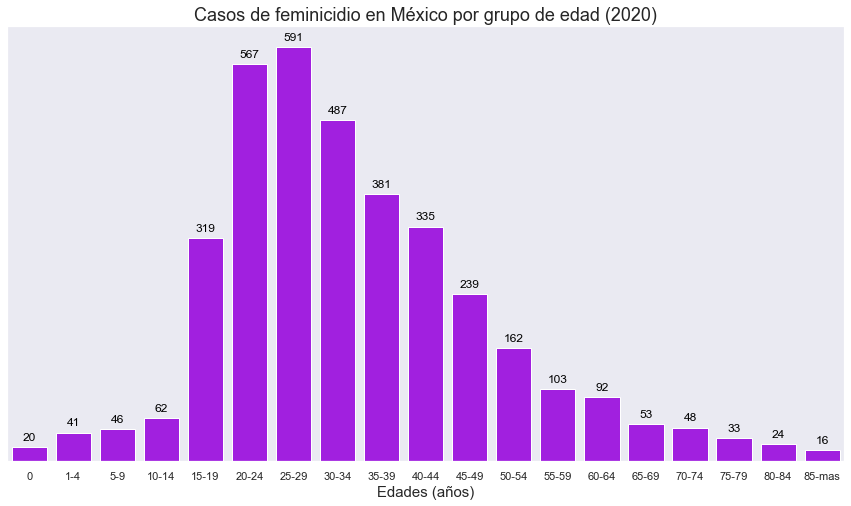

In [6]:
# Se establece el tamaño de la gráfica y el color del fondo
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_style("dark")

# Se grafica la figura
barplot = sns.barplot(
    data=df_edades, 
    estimator=sum, 
    ci=None, 
    color=(172/255,0,255/255,0.87)
)
barplot.set_title("Casos de feminicidio en México por grupo de edad (2020)", fontsize = 18)
barplot.set_xlabel("Edades (años)", fontsize = 15)
barplot.axes.yaxis.set_ticklabels([])

# Se grafica el valor de cada barra
i = 0
for col in df_edades.columns[1:]:
    value = df_edades[col].sum()
    barplot.text(i,value+10, int(value), color='black', ha="center")
    i += 1

Se puede observar cómo la distribución se asemeja a una normal ligeramente sesgada hacia la derecha. También podemos ver que lamentablemente el 4.67% de los casos corresponden a mujeres infantes y adolescentes (entre 0 y 14 años). Además podemos discernir fácilmente que la mayoría de mujeres asesinadas son personas jóvenes con entre 15 y 44 años de edad, estos rangos de edad abarcan el 74% de los casos.

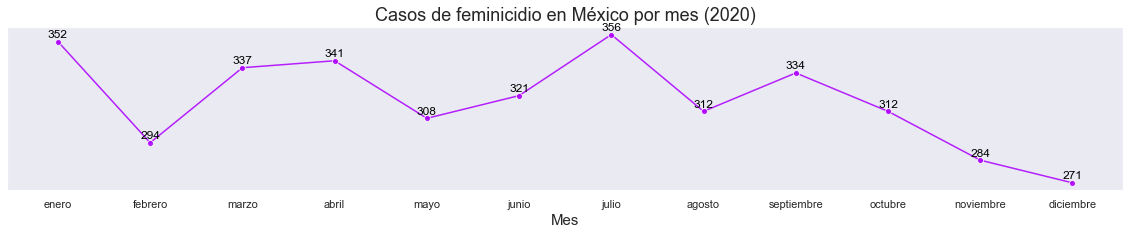

In [7]:
# Se establece el tamaño de la gráfica y el color del fondo
sns.set(rc = {'figure.figsize':(20,3)})
sns.set_style("dark")

# Se grafica la serie de tiempo
lineplot = sns.lineplot(
    data=[df_mes[m].sum() for m in df_mes.columns[1:]],
    color=(172/255,0,255/255,0.87),
    markers=True,
    marker='o'
)
lineplot.set_title("Casos de feminicidio en México por mes (2020)", fontsize = 18)
lineplot.set_xlabel("Mes", fontsize = 15)
plt.xticks(range(12), df_mes.columns[1:])
lineplot.axes.yaxis.set_ticklabels([])

# Se añade el valor para cada mes
i = 0
for col in df_mes.columns[1:]:
    value = df_mes[col].sum()
    
    lineplot.text(i,value+2, int(value), color='black', ha="center")
    i += 1

El número de feminicidios permaneció alto y con relativamente con poca variación, entre 271 y 352 casos mensuales. Lo que sí es importante remarcar es que en el último trimestre del año el número de casos fue a la baja.

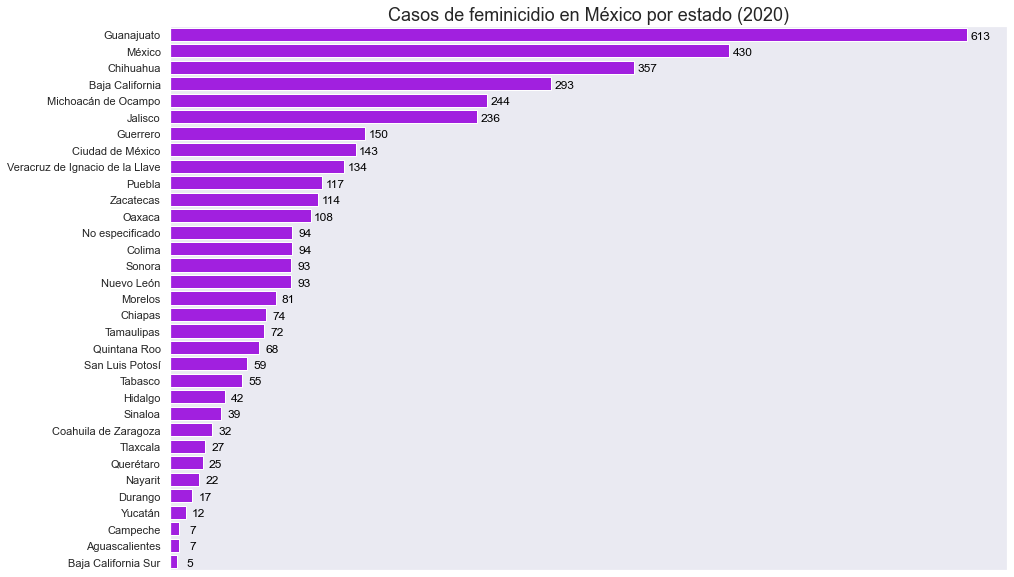

In [8]:
# Se establece el tamaño de la gráfica y el color del fondo
sns.set(rc = {'figure.figsize':(15,10)})
sns.set_style("dark")

# Se reordena el dataframe para visualizar mejor el resultado
df_total_ordenado = df_total.sort_values('mujer', ascending=False)
# Se grafica la figura
barplot = sns.barplot(
    data=df_total_ordenado, x='mujer', y='estado',
    estimator=sum, ci=None, orient='h',
    color=(172/255,0,255/255,0.87)
)
barplot.set_title("Casos de feminicidio en México por estado (2020)", fontsize = 18)
barplot.set_xlabel("")
barplot.set_ylabel("")
barplot.axes.xaxis.set_ticklabels([])

# Se añade el valor de cada barra
for i in range(len(df_total_ordenado)):
    value = df_total_ordenado.iloc[i,1]
    barplot.text(value+10,i+.25, int(value), color='black', ha="center")

Podemos observar que, por mucho, la entidad federativa con más feminicidios es Guanajuato. Sonora se encuentra en el decimocuarto sitio (sin contar la entidad `No especificado`).

## Prueba de hipótesis

Como la información proporcionada por el INEGI corresponde a los datos de un año completo necesitamos modificar nuestra hipótesis. Los medios de comunicación establecen que diariamente asesinan a 10 mujeres, si tomamos en cuenta este dato como verdadero, entonces **cada año el número de mujeres asesinadas es de 3,650**. Ahora, para obtener la probabilidad de que una mujer sea asesinada debemos considerar el número de mujeres en México. De acuerdo al INEGI [[6]](https://www.inegi.org.mx/contenidos/saladeprensa/aproposito/2021/mujer2021_Nal.pdf), en 2020 el 51.2% de la población mexicana total eran mujeres, es decir **64,540,634**. Conociendo esta información podemos comenzar con la prueba de hipótesis.

Se obtiene el número de mujeres asesinadas en el 2020

In [9]:
x = df_total.mujer.sum()
print(f"Número de mujeres asesinadas en el 2020: {x}")

Número de mujeres asesinadas en el 2020: 3957


Los datos

* $X = \text{Número de mujeres asesinadas en México}$
* $x = \text{Número real de mujeres asesinadas en México en el 2020} = 3,957$
* $n = \text{Número total de mujeres en México} = 64,540,634$
* $p_0 = \text{Prob. de que una mujer sea asesinada en México} = \frac{\text{Número de mujeres asesinadas al año en México}}{\text{Número de mujeres en México}} = \frac{3,650}{n} = \frac{3,650}{64,540,634} = 5.65x10^{-5}$

Ahora, establecemos las hipótesis

* $H_0: p = p_0 = 5.65x10^{-5}$
* $H_1: p > p_0 = 5.65x10^{-5}$

Luego, definimos el estimador y el estadístico de prueba

* $\hat{p} = \frac{x}{n} = \frac{3,957}{64,540,634} = 6.13x10^{-5}$
* $Z_c = \frac{\hat{p}-p_0}{\sqrt{\frac{p_0(1-p_0)}{n}}}$

Podemos usar este estadístico de prueba porque podemos suponer que $X \sim Binom(n,p_0)$ y el parámetro $n$ es "muy grande".

Como nuestra hipótesis alternativa es $H_1: p > p_0$, entonces rechazaremos la hipótesis nula $H_0$ si $Z_c > Z_{1-\alpha}$. La prueba de hipótesis se realizará con un nivel de confianza del 95%, es decir $\alpha = .05$. A continuación se realizarán los cálculos correspondientes.

In [10]:
# Variable aleatoria: X = Número de mujeres asesinadas en México

x = 3957 # Número real de mujeres asesinadas en México en el 2020
n = 64540634 # Número total de mujeres en México
p_0 = 3650/n # Prob. de que una mujer sea asesinada en México

p_hat = x/n # Estimador 
alpha = .05 # Nivel de significancia

Z_c = ( p_hat-p_0 )/( (p_0*(1-p_0))/n )**(1/2) # Estadístico de prueba
Z_1_sub_alpha = norm.ppf(1-alpha,loc=0,scale=1) # Se calcula Z_{1-alpha}


print(f"Núm. real de mujeres asesinadas en México (x): {x}")
print(f"Núm. total de mujeres en México (x): {n}")
print(f"Prob. de que una mujer sea asesinada en México (p_0): {p_0}")
print(f"Estimador (p_hat): {p_hat}")
print(f"Nivel de significancia (alpha): {alpha}")
print("\n")

print(f"Estadístico de prueba (Z_c): {Z_c}")
print(f"Z_{{1-alpha}} = {Z_1_sub_alpha}")
print("\n")

print("Resultado de la prueba de hipótesis")

if Z_c > Z_1_sub_alpha:
    print("Z_c > Z_{1-alpha}. Por lo tanto se rechaza H_0")
else:
    print("Z_c <= Z_{1-alpha}. Por lo tanto no se puede rechazar H_0")


Núm. real de mujeres asesinadas en México (x): 3957
Núm. total de mujeres en México (x): 64540634
Prob. de que una mujer sea asesinada en México (p_0): 5.6553519446369245e-05
Estimador (p_hat): 6.131021272583099e-05
Nivel de significancia (alpha): 0.05


Estadístico de prueba (Z_c): 5.081643850472337
Z_{1-alpha} = 1.6448536269514722


Resultado de la prueba de hipótesis
Z_c > Z_{1-alpha}. Por lo tanto se rechaza H_0


El resultado de la prueba de hipótesis nos dice que existe evidencia suficiente para rechazar $H_0$ a un nivel de $\alpha = .05$; es decir, **podemos sospechar de que no es cierto que el número de mujeres asesinadas diariamente en México es igual a diez, si no que el número es mayor**.

## En busca de la verdad

Con un 95% de confianza podemos decir que en México asesinan a más de 10 mujeres al día. A continuación, buscaremos el número de mujeres asesinadas que más se acerque a la realidad pero ahora mediante pruebas de hipótesis de dos colas.

Todos los datos permanecerán constantes a excepción de $p_0$ porque el número de mujeres asesinadas al año variará y $Z_c$ ya que éste depende de $p_0$; además, ahora necesitaremos calcular $Z_{1-\frac{\alpha}{2}}$ y $-Z_{1-\frac{\alpha}{2}}$, valores que marcarán las regiones de rechazo de la prueba de hipótesis.

Nuevas hipótesis

* $H_0: p = p_0$
* $H_1: p \neq p_0$

Para encontrar el rango más probable de mujeres asesinadas en México se realizarán $m$ pruebas de hipótesis partiendo de que el número de asesinatos diarios es 0.1. En algún momento, para cierta $p_0$, la hipótesis nula dejará de rechazarse y esto marcará el límite inferior de nuestro intervalo. El algoritmo terminará hasta que $H_0$ vuelva a rechazarse, con lo que habremos encontrado el límite superior del intervalo.

In [11]:
asesinatos_diarios = 0.1 # Número de asesinatos diarios que vamos a variar

# Límites del intervalo de asesinatos
limite_inf = None
limite_sup = None

# Se busca el límite inferior (Cuando H_0 deja de rechazarse)
while limite_inf == None:
    p_0 = 365*asesinatos_diarios/n # Prob. de que una mujer sea asesinada en México

    Z_c = ( p_hat-p_0 )/( (p_0*(1-p_0))/n )**(1/2) # Estadístico de prueba
    Z_1_sub_alpha_div_2 = norm.ppf(1-(alpha/2),loc=0,scale=1) # Se calcula Z_{1-(alpha/2)}
    
    # Si H_0 se acepta, hemos encontrado el primer valor para el cuál H_0 se acepta
    if not (Z_c > Z_1_sub_alpha_div_2 or Z_c < -Z_1_sub_alpha_div_2):
        limite_inf = asesinatos_diarios
        break
    
    asesinatos_diarios += .1

# Se busca el límite superior (Cuando H_0 vuelve a rechazarse)
while limite_sup == None:
    p_0 = 365*asesinatos_diarios/n # Prob. de que una mujer sea asesinada en México

    Z_c = ( p_hat-p_0 )/( (p_0*(1-p_0))/n )**(1/2) # Estadístico de prueba
    Z_1_sub_alpha_div_2 = norm.ppf(1-(alpha/2),loc=0,scale=1) # Se calcula Z_{1-(alpha/2)}
    
    # Si H_0 se rechaza, hemos encontrado el primer valor para el cual H_0 comienza a ser
    # "falsa" de nuevo
    if Z_c > Z_1_sub_alpha_div_2 or Z_c < -Z_1_sub_alpha_div_2:
        if limite_sup == None:
            limite_sup = asesinatos_diarios
            break
    
    asesinatos_diarios += .1

print(f"Intervalo más probable de mujeres asesinadas en México: [{limite_inf}, {limite_sup}]")
    

Intervalo más probable de mujeres asesinadas en México: [10.599999999999978, 11.199999999999976]


## Conclusiones

La distribución por edades del número de casos de feminicidios parece seguir una distribución normal. De esta representación de los datos pudimos observar que el 74% de las mujeres asesinadas tenían la edad de entre 15 y 44 años; además, el 4.67% de los casos corresponden a niñas y adolescentes. También observamos que en el 2020 el número de feminicidios permaneció muy alto pero con poca variación a lo largo del año presentando una tendencia a la baja en los últimos tres meses. Asimismo, obtuvimos que Guanajuato, el Estado de México y Chihuahua son las tres entidades federativas con el mayor número de feminicidios registrados. Sonora se encuentra en el decimocuarto puesto.

De la prueba de hipótesis podemos concluir que, con un nivel de confianza del 95%, en México son asesinadas entre 10.6 y 11.2 mujeres diariamente, para fines prácticos podemos establecer este número en 11. Esto es alarmante porque significa que las medidas tomadas (si es que existe alguna) para menguar este grave problema están fracasando; además, el incremento en un caso diario supone un incremento de 365 asesinatos en un año. Desgraciadamente tenemos que comenzar a hablar de 11 mujeres asesinadas al día así como algunas fuentes que ya han encontrado y reportado esta nueva cifra con anterioridad [[7]](https://elpais.com/mexico/2021-11-25/mexico-el-fracaso-en-frenar-los-feminicidios.html#:~:text=Cualquier%20cifra%20en%20torno%20a,a%20denunciar%20a%20su%20agresor.), [[8]](https://www.meganoticias.mx/cdmx/noticia/en-mexico-son-asesinadas-11-mujeres-al-dia/289000), [[9]](https://www.youtube.com/watch?v=raOTW6RxY_I).